In [1]:
import keras
import tensorflow as tf
# in my setup, keras is running on top of TensorFlow. 
import pandas
from matplotlib import pyplot as plt
import math 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import time
from pandas import DataFrame
# set up keras on top of tensorflow
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"]="1"
print("python:{}, keras:{}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

Using TensorFlow backend.


python:3.6.1 |Anaconda 4.4.0 (64-bit)| (default, May 11 2017, 13:25:24) [MSC v.1900 64 bit (AMD64)], keras:2.0.5, tensorflow: 1.2.0


persistence is 0.011222
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (4, 8)                    320       
_________________________________________________________________
dropout_1 (Dropout)          (4, 8)                    0         
_________________________________________________________________
dense_1 (Dense)              (4, 1)                    9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Train on 1208 samples, validate on 48 samples
Epoch 1/50
2s - loss: 0.0203 - val_loss: 0.0018
Epoch 2/50
1s - loss: 0.0087 - val_loss: 9.7450e-04
Epoch 3/50
1s - loss: 0.0056 - val_loss: 9.3285e-04
Epoch 4/50
1s - loss: 0.0047 - val_loss: 0.0084
Epoch 5/50
1s - loss: 0.0040 - val_loss: 5.2148e-04
Epoch 6/50
1s - loss: 0.0034 - val_loss: 0.0013
Epoch 7/50
1s - loss: 0.0028 - val_los

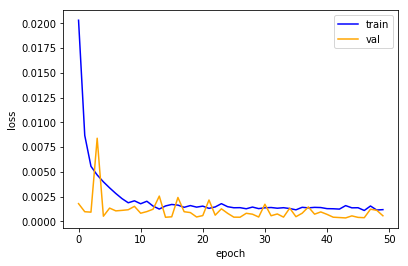

Training takes 74.691619 seconds


In [2]:
batch_size = 4
num_iters=50
n_reps=1 # number of diagonistic run
num_neurons=8
bag_size=10
states=True
data=pandas.read_csv('JPM.csv',usecols=[5],engine='python',skipfooter=1)
data=data.values
data=data.astype('float32')
scaler=MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(data)
# seperate the data into training and test 
def split_data(data,train_ratio):
    train_size=int(len(data)*train_ratio)
    test_size=len(data)-train_size
    train,test=data[0:train_size,:], data[train_size:len(data),:]
    return train,test
train, val, test=data[:1219], data[1220:1279], data[1268:1300]
persistence=math.sqrt(mean_squared_error(data[1:],data[:-1]))
print('persistence is %f' % (persistence))
math.sqrt(mean_squared_error(data[1:],data[:-1]))
# transform the data into patch of time series 
def create_seq(data,bag_size):
    bag_size=int(bag_size)
    datax,datay=[],[]
    for i in range(len(data)-1-bag_size):
        tp=data[i:(i+bag_size),0]
        datax.append(tp)
        datay.append(data[i+bag_size,0])
    return np.array(datax),np.array(datay)
test_x,test_y=create_seq(test,bag_size)
val_x,val_y=create_seq(val,bag_size)
train_x,train_y=create_seq(train,bag_size)
# reformat the data as (sample, time_step, features) to feed into LSTM model 
train_x=np.reshape(train_x, (train_x.shape[0],train_x.shape[1],1))
test_x=np.reshape(test_x, (test_x.shape[0],test_x.shape[1],1))
val_x=np.reshape(val_x, (val_x.shape[0],val_x.shape[1],1))

def evaluate_model(model,train_x,test_x, train_y, test_y, scaler, batch_size):
    train_predict=model.predict(train_x,batch_size=batch_size)
    test_predict=model.predict(test_x,batch_size=batch_size)
    # reverse_scale the data to the original unit
    train_predict=scaler.inverse_transform(train_predict)
    test_predict=scaler.inverse_transform(test_predict)
    train_y=scaler.inverse_transform([train_y])
    test_y=scaler.inverse_transform([test_y])
    train_score=math.sqrt(mean_squared_error(train_y[0], train_predict[:,0]))
    test_score=math.sqrt(mean_squared_error(test_y[0], test_predict[:,0]))
    return train_score,test_score

# set up the LSTM network 
with tf.device('/cpu:0'):
    model = Sequential()
   # model.add(LSTM(num_neurons, batch_input_shape=(batch_size, bag_size, 1), stateful=states, return_sequences=True))
    #model.add(Activation('relu'))
  #  model.add(Dropout(0.2))   
    model.add(LSTM(num_neurons, batch_input_shape=(batch_size, bag_size, 1), stateful=states,return_sequences=False ))
   # model.add(Activation('relu'))
    model.add(Dropout(0.2))  
    # model.add(LSTM(4, input_shape=(bag_size,1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    model.summary()
    start=time.time()
    for i in range(n_reps):
        history=model.fit(train_x,train_y, epochs=num_iters, batch_size=batch_size, verbose=2, \
                          validation_data=(val_x, val_y), shuffle=True)
        plt.plot(history.history['loss'], color='blue')
        plt.plot(history.history['val_loss'], color='orange')
        model.reset_states()
    plt.ylabel('loss') 
    plt.xlabel('epoch') 
    plt.legend(['train', 'val'], loc='best') 
    plt.savefig('layers_2'+'_neurons_'+str(num_neurons)+'_epochs_'+str(num_iters)+ \
                '_lookback_'+ str(bag_size)+'_stateful_'+str(states)+'.png',dpi=300,format='png')
    plt.show()
    training_time=time.time()-start
    print('Training takes %f seconds' %(training_time))

train_y=scaler.inverse_transform([train_y])
test_y=scaler.inverse_transform([test_y])

In [3]:
# copy the weights from the trained model, so that we can predict with batch size ==1
new_model = Sequential()
#new_model.add(LSTM(num_neurons, batch_input_shape=(1, bag_size, 1), stateful=states, return_sequences=True))
#model.add(Activation('relu'))
#new_model.add(Dropout(0.2))   
new_model.add(LSTM(num_neurons, batch_input_shape=(1, bag_size, 1), stateful=states,return_sequences=False ))
new_model.add(Dropout(0.2))  
new_model.add(Dense(1))
old_weights = model.get_weights()
new_model.set_weights(old_weights)
new_model.compile(loss='mean_squared_error',optimizer='adam')


Train Score: 0.97 RMSE
Test Score: 1.64 RMSE


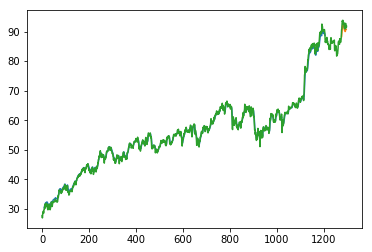

Saved model to disk


In [4]:
train_predict=new_model.predict(train_x,batch_size=1)
test_predict=new_model.predict(test_x,batch_size=1)
# reverse_scale the data to the original unit
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
train_score=math.sqrt(mean_squared_error(train_y[0], train_predict[:,0]))
test_score=math.sqrt(mean_squared_error(test_y[0], test_predict[:,0]))
print('Train Score: %.2f RMSE' %(train_score))
print('Test Score: %.2f RMSE' %(test_score))

# plot the training 
train_predict_plot=np.empty_like(data)
train_predict_plot[:,:]=np.nan
train_predict_plot[bag_size:len(train_predict)+bag_size, :] = train_predict
test_predict_plot=np.empty_like(data)
test_predict_plot[:,:]=np.nan
test_predict_plot[len(train_predict)+len(val_y)+bag_size*2+1: \
                  len(train_predict)+len(val_y)+len(test_predict)+bag_size*2+1, :] = test_predict
plt.plot(train_predict_plot[1:np.shape(train_y)[1],0])
plt.plot(test_predict_plot[:,0])
plt.plot(scaler.inverse_transform(data))
plt.savefig('Train_versus_test_layers_2'+'_neurons_'+str(num_neurons)+'_epochs_'+str(num_iters)+ \
                '_lookback_'+ str(bag_size)+'_stateful_'+str(states)+'.png',dpi=300,format='png')
plt.show()
####save the trained model 
#serialize model to JSON
from keras.models import model_from_json
model_json = model.to_json()
with open('layers_2'+'_neurons_'+str(num_neurons)+'_epochs_'+str(num_iters)+ \
                '_lookback_'+ str(bag_size)+'_stateful_'+str(states)+'.json', "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights('layers_2'+'_neurons_'+str(num_neurons)+'_epochs_'+str(num_iters)+ \
                '_lookback_'+ str(bag_size)+'_stateful_'+str(states)+'.h5')
print("Saved model to disk")


In [5]:
from numpy import newaxis
def predict_sequences_multiple(model, data, window_size, prediction_len,scaler):
#Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(np.shape(train_x)[0]/prediction_len)):
        curr_frame = data[i*prediction_len,:,:]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(scaler.inverse_transform(predicted))
    return prediction_seqs
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data[0], label='True Data',color='black')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, d in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(np.concatenate((padding,d), axis=0), color='red')
    plt.show()
    plt.savefig('10_days_prediction.png',dpi=300,format='png')
predicted_y=predict_sequences_multiple(new_model, train_x, bag_size, bag_size,scaler)


D:\other_installed_software\anaconda\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\other_installed_software\anaconda\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\other_installed_software\anaconda\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(

D:\other_installed_software\anaconda\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\other_installed_software\anaconda\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\other_installed_software\anaconda\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(

D:\other_installed_software\anaconda\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\other_installed_software\anaconda\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\other_installed_software\anaconda\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(

D:\other_installed_software\anaconda\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\other_installed_software\anaconda\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\other_installed_software\anaconda\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(

D:\other_installed_software\anaconda\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\other_installed_software\anaconda\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\other_installed_software\anaconda\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(

D:\other_installed_software\anaconda\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\other_installed_software\anaconda\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\other_installed_software\anaconda\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(

<IPython.core.display.Javascript object>


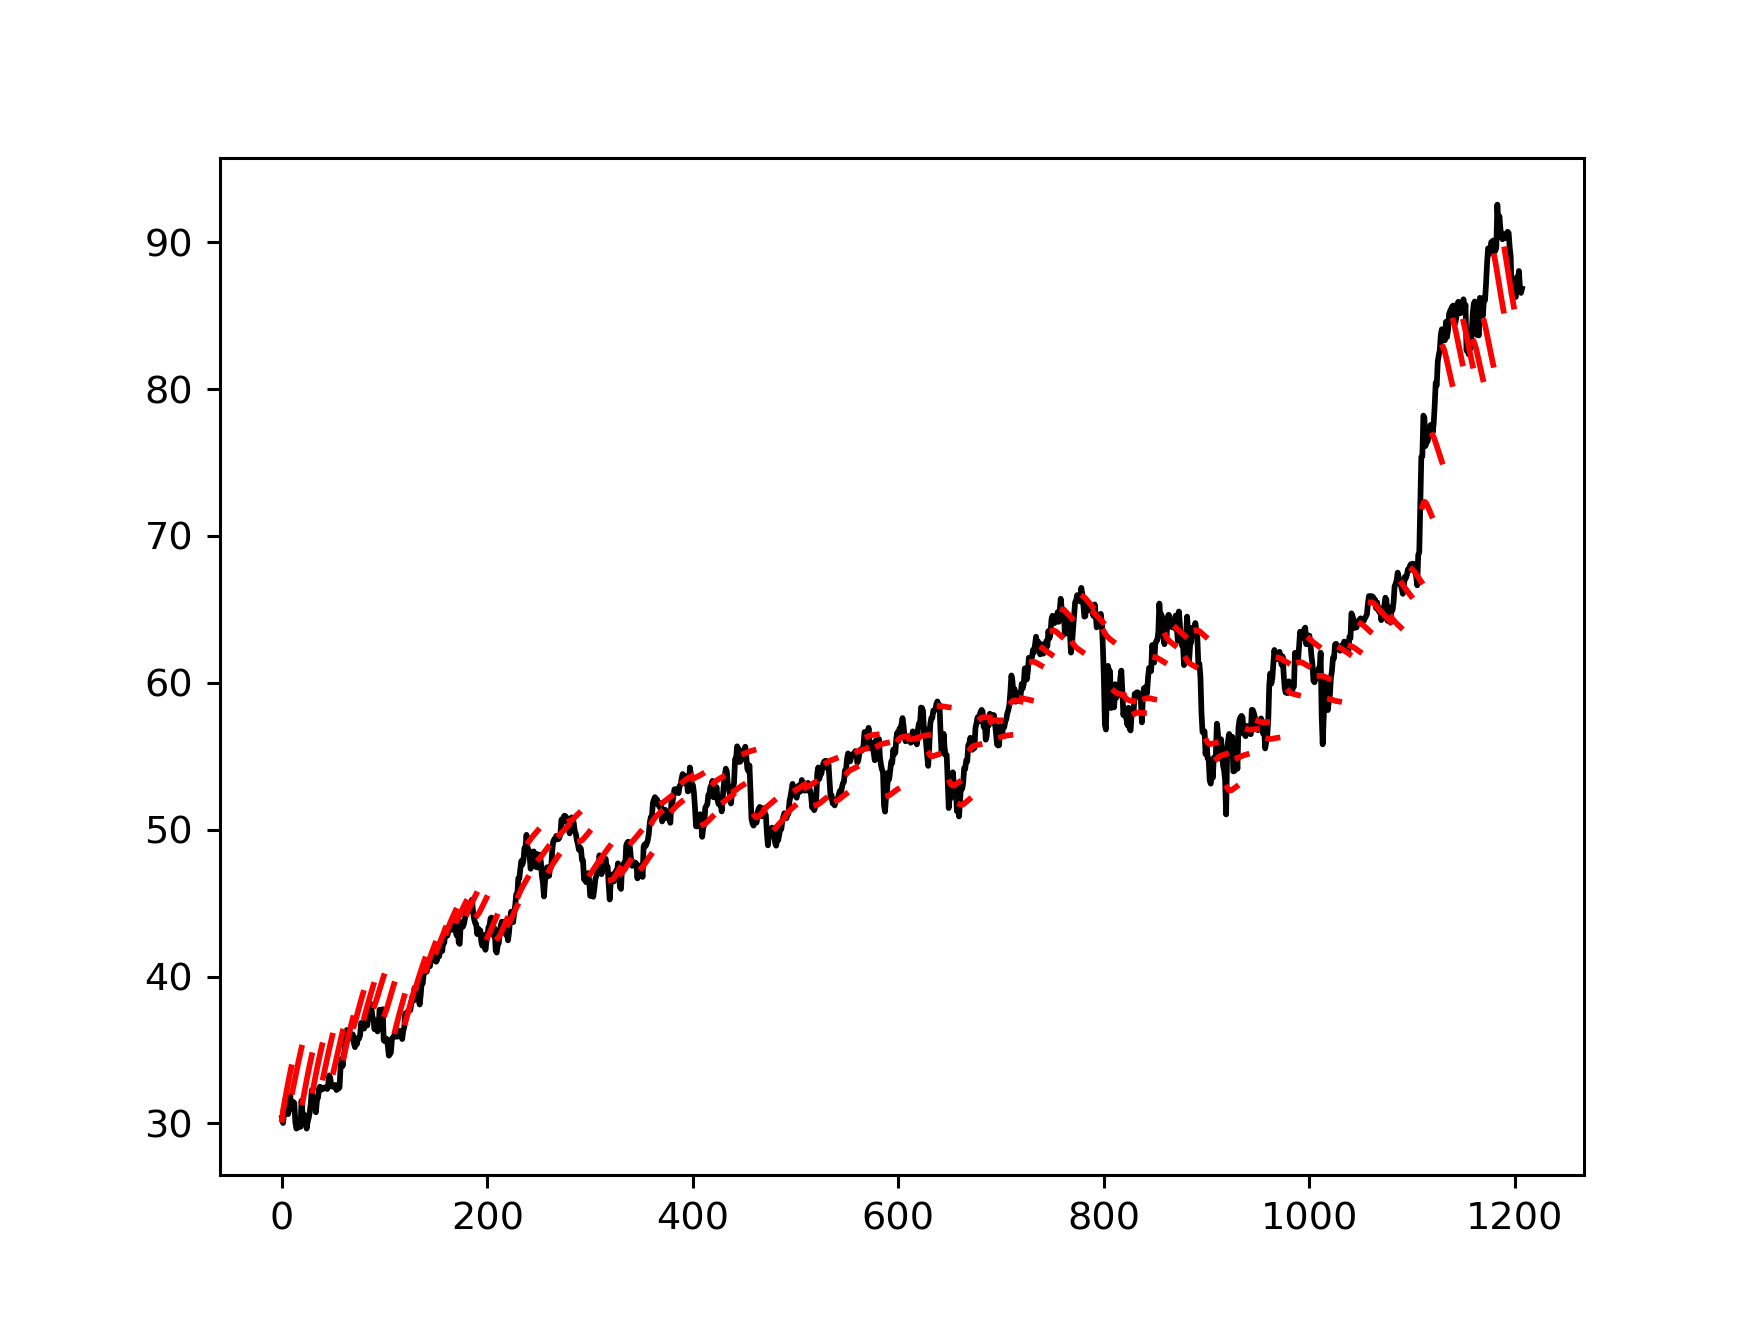

In [6]:
%matplotlib notebook
plot_results_multiple(predicted_y, train_y, bag_size)